In [0]:
import keras

from keras.datasets import reuters
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os

import matplotlib.pyplot as plt

# https://github.com/tongzhang1995/neural_network/blob/master/NLP.ipynb
# https://towardsdatascience.com/text-classification-in-keras-part-1-a-simple-reuters-news-classifier-9558d34d01d3
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.3,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)


In [0]:
# exploramos os dados

# info: https://keras.io/datasets/

# word index utilizado para codificar as sequencias
word_index = reuters.get_word_index(path="reuters_word_index.json")

print('# of Training Samples: {}'.format(len(x_train)))
print('# of Test Samples: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('# of Classes: {}'.format(num_classes))

# of Training Samples: 8982
# of Test Samples: 2246
# of Classes: 46
index_to_word = {}
for key, value in word_index.items():
    index_to_word[value] = key

# caracteristicas de um example
print('# features:')
print(' '.join([index_to_word[x] for x in x_train[0]]))
print('# label: ', y_train[0])

# of Training Samples: 7859
# of Test Samples: 3369
# of Classes: 46
# features:
the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs
# label:  3


In [0]:
# construimos o modelo

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

tokenizer = Tokenizer(num_words=max_features)
x_train = tokenizer.sequences_to_matrix(x_train, mode='count') # mode :frequency, count, tfidf, count
x_test = tokenizer.sequences_to_matrix(x_test, mode='count')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# avaliamos a forma dos  dados
print(x_train.shape)
print(x_train[0])
print(len(x_train[0]))
print(max(x_train[0]))

print(y_train.shape)
print(y_train[0])



(7859, 10000)
[0. 1. 0. ... 0. 0. 0.]
10000
6.0
(7859, 46)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:

# modelo
model = Sequential()
model.add(Dense(512, input_shape=(max_features,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               5120512   
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 46)                23598     
_________________________________________________________________
activation_6 (Activation)    (None, 46)                0         
Total params: 5,144,110
Trainable params: 5,144,110
Non-trainable params: 0
_________________________________________________________________


In [0]:
# configurar Tensorboard mediante um firewall
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')A



--2019-10-20 02:01:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.156.217.124, 52.205.50.157, 54.152.127.232, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.156.217.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.13M  6.64MB/s    in 2.0s    

2019-10-20 02:01:52 (6.64 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   


In [0]:
# obtenemos a url
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

#!ps aux | grep tensorboard

In [0]:
import math

batch_size = 32
epochs = 10

# modelcheckpoint sirve para grabar em cada iteração 

model_path="model.hdf5"

checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="loss", mode="min", patience=10)
#csv_logger = CSVLogger('logg/log.csv', append=True)
#tb = TensorBoard(log_dir='./log', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
#tb = TensorBoard(log_dir='./log', histogram_freq=1, write_graph=True, write_grads=True, batch_size=batch_size, write_images=True)
tb = TensorBoard(log_dir='./log', batch_size=batch_size, write_graph=True, update_freq='batch')


# treinamos o modelo
#history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

history = model.fit(x_train, y_train,
                            epochs=epochs, 
                            verbose=1,
                            validation_data=(x_test, y_test),
                            validation_steps=math.ceil(len(x_test)/batch_size),
                            steps_per_epoch=math.ceil(len(x_train)/batch_size),
                            callbacks=[checkpoint, early, tb])
'''

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[checkpoint, early,tb])
'''

Train on 7859 samples, validate on 3369 samples
Epoch 1/10
246/246 [==============================] - 78s 318ms/step - loss: 0.2510 - acc: 0.9491 - val_loss: 0.8823 - val_acc: 0.8157

Epoch 00001: loss improved from inf to 0.25096, saving model to model.hdf5
Epoch 2/10
246/246 [==============================] - 78s 319ms/step - loss: 0.2188 - acc: 0.9541 - val_loss: 0.8876 - val_acc: 0.8148

Epoch 00002: loss improved from 0.25096 to 0.21883, saving model to model.hdf5
Epoch 3/10
246/246 [==============================] - 79s 320ms/step - loss: 0.1932 - acc: 0.9579 - val_loss: 0.8948 - val_acc: 0.8151

Epoch 00003: loss improved from 0.21883 to 0.19321, saving model to model.hdf5
Epoch 4/10
246/246 [==============================] - 79s 319ms/step - loss: 0.1707 - acc: 0.9607 - val_loss: 0.9040 - val_acc: 0.8148

Epoch 00004: loss improved from 0.19321 to 0.17066, saving model to model.hdf5
Epoch 5/10
246/246 [==============================] - 78s 319ms/step - loss: 0.1513 - acc: 0.962

KeyboardInterrupt: ignored

3369/3369 [==============================] - 0s 112us/step
Test loss: 0.9551920178170797
Test accuracy: 0.8153754823920493


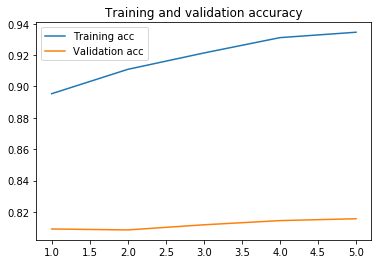

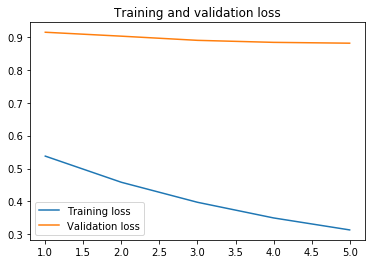

In [0]:
#evaluamos o modelo
model.load_weights(model_path)

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# apagamos o directorio
!rm -rf log